In [1]:
import math
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib
import urllib.request as urlreq
import json
from math import *
from functools import reduce


In [2]:
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76.0) Gecko/20100101 Firefox/76.0'}
url = 'https://blocks.flashbots.net/v1/blocks?limit=10000'
req = urlreq.Request(url=url, headers=headers)
data = urlreq.urlopen(req).read()
dic = json.loads(data)
latest = dic["latest_block_number"]
blocks = dic["blocks"]

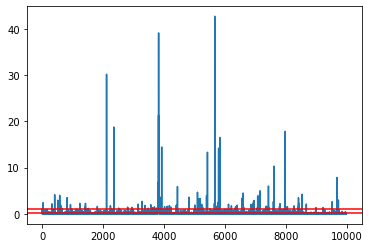

In [3]:
weiToEth = 10**-18
EthToGwei = 10**9
gweiToEth = 10**(-9)
weiToGwei = 10**(-9)
GweiToWei = 10**9
blocks = [block for block in blocks if int(block["miner_reward"]) > 0]
rewards = np.array([int(block["miner_reward"]) for block in blocks])*weiToEth
n_blocks = min(10000, len(rewards))
plt.plot(rewards[0:n_blocks])
mean = np.mean(rewards[0:n_blocks])
std = np.std(rewards[0:n_blocks])
plt.axhline(y = mean, color='r')
plt.axhline(y = mean + std, color='r')
plt.show()

Median fee: 113.13708498984039
Mean fee: 149.80795926278023
Average burn percentage: 0.8075774669504854
Total burn percentage: 0.4175578840958033
Average burn percentage without outliers: 0.8195876040738176
Total burn percentage without outliers: 0.6019421184772269
Percentage of missed slots: 0.5711571157115711
outliers: 196


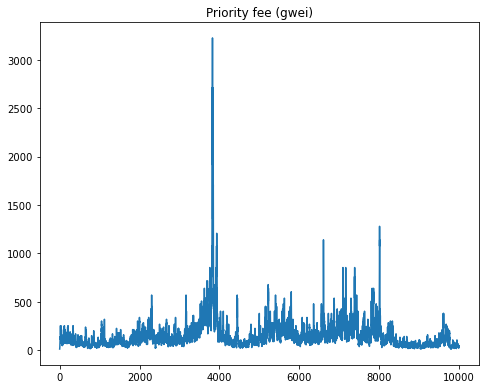

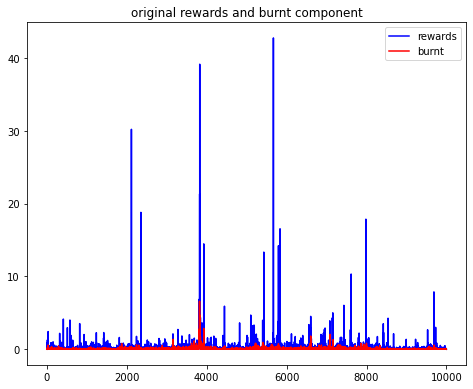

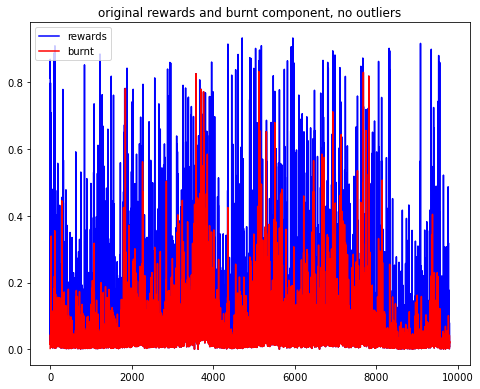

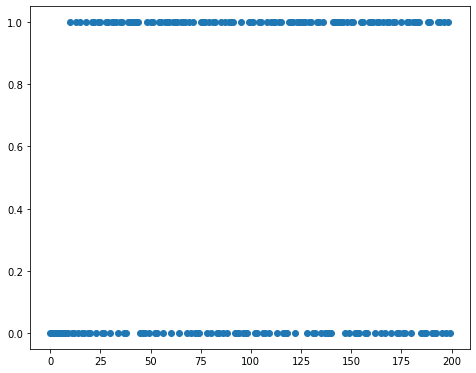

In [10]:
resize = 0.8
plt.rcParams['figure.figsize'] = [resize*25/2.54, resize*20/2.54]
gas_used = lambda block: int(block["gas_used"])
gas_price = lambda block: int(block["gas_price"])*weiToEth
miner_reward = lambda block: int(block["miner_reward"])*weiToEth
priority_fee = 10 #10 gwei
new_rewards = np.zeros(n_blocks)
fee = np.zeros(n_blocks)
fee[0] = priority_fee
doubling_days = 3
halfing_days = 4
increase_factor = np.exp((log(2)/doubling_days))
decrease_factor = np.exp((log(0.5)/halfing_days))
for i, block in enumerate(blocks):
    burnt = gas_used(block)*priority_fee*gweiToEth
    new_rewards[i] = max(rewards[i] - burnt, 0)
    if new_rewards[i] > 0:
        priority_fee *= increase_factor
    elif rewards[i]*1.1 > burnt:
        new_rewards[i] = rewards[i]*1.1 - burnt
        priority_fee *= increase_factor
    else:
        priority_fee *= decrease_factor
    fee[i] = priority_fee
    
burnt = rewards - new_rewards
plt.plot(fee)
plt.title("Priority fee (gwei)")
plt.figure()
plt.plot(rewards, color = 'b')
plt.plot(burnt, color = 'r')
plt.legend(["rewards", "burnt"])
plt.title("original rewards and burnt component")
mean = np.mean(rewards)
var = np.var(rewards)
non_outliers = [i for i, r in enumerate(rewards) if r < mean + var]
plt.figure()
plt.title("original rewards and burnt component, no outliers")
plt.plot(rewards[non_outliers], color = 'b')
plt.plot(burnt[non_outliers], color = 'r')
plt.legend(["rewards", "burnt"])
plt.figure()
plt.scatter(range(200), [1 if t else 0 for t in (new_rewards == 0)][0:200])
print("Median fee: {}".format(np.median(fee)))
print("Mean fee: {}".format(np.mean(fee)))
print("Average burn percentage: {}".format(np.mean(burnt/rewards)))
print("Total burn percentage: {}".format(np.sum(burnt)/np.sum(rewards)))
print("Average burn percentage without outliers: {}".format(np.mean(burnt[non_outliers]/rewards[non_outliers])))
print("Total burn percentage without outliers: {}".format(np.sum(burnt[non_outliers])/np.sum(rewards[non_outliers])))
print("Percentage of missed slots: {}".format(np.mean(new_rewards == 0)))
print("outliers: {}".format(n_blocks - len(non_outliers)))
plt.show()

0.7741436405141126
0.02282171229129314


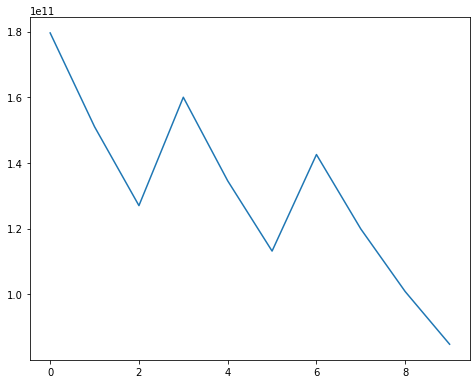

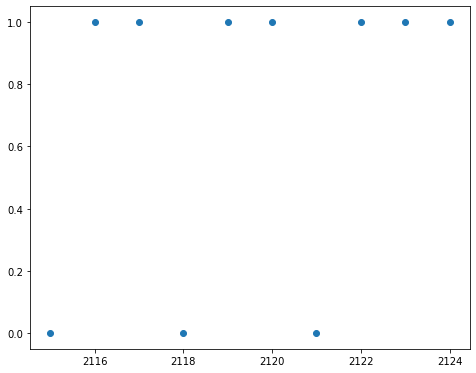

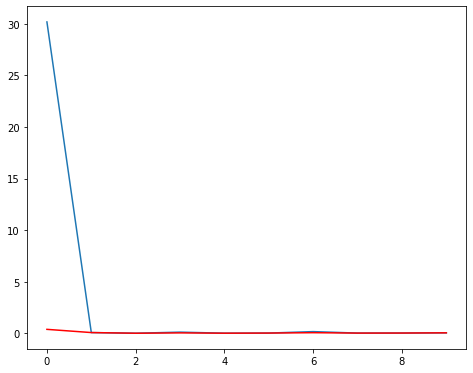

In [5]:
a = 2115
b = 2125
plt.plot(fee[a:b]*EthToGwei)
plt.figure()
plt.scatter(range(a,b), [1 if t else 0 for t in (new_rewards == 0)][a:b])
plt.figure()
plt.plot(rewards[a:b])
plt.plot(burnt[a:b], color = 'r')
print(np.mean(burnt[a:b]/rewards[a:b]))
print(np.sum(burnt[a:b])/np.sum(rewards[a:b]))

Median fee: 61.30665047275269
Mean fee: 98.83663510540796
Average burn percentage: 0.5495217105444886
Total burn percentage: 0.2350124790555735
Average burn percentage without outliers: 0.5581521695505741
Total burn percentage without outliers: 0.3312907383144821
outliers: 196
Median gas used: 567973.0
Mean gas used: 666353.2737273728
Median priority gas: 168526.0
Mean priority gas: 228362.17551755175


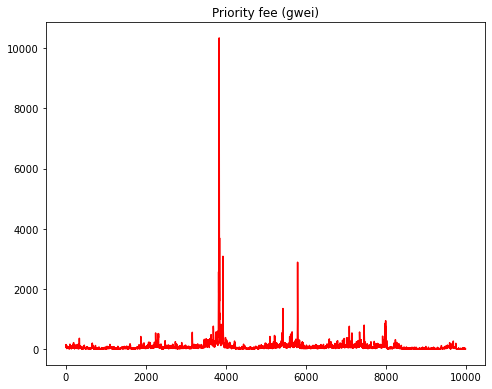

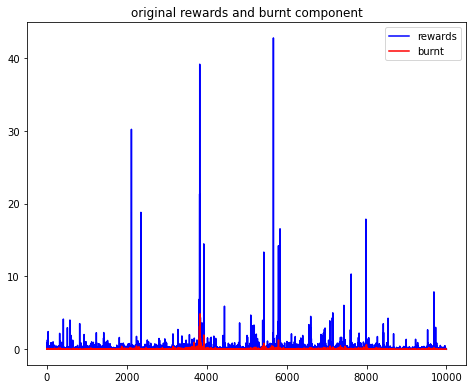

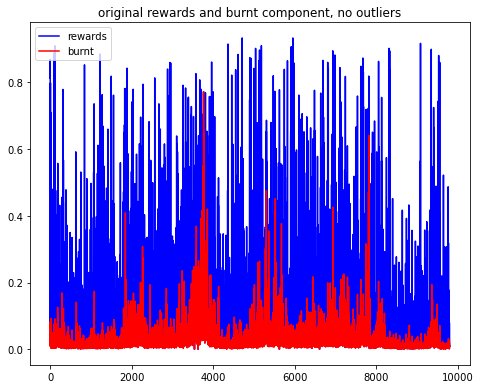

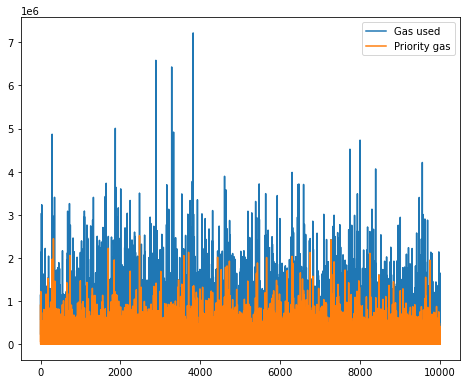

In [11]:
# PRICING WITH PRIORITY GAS TARGET
resize = 0.8
plt.rcParams['figure.figsize'] = [resize*25/2.54, resize*20/2.54]
gas_used = lambda block: int(block["gas_used"])
gas_price = lambda block: int(block["gas_price"])*weiToEth
miner_reward = lambda block: int(block["miner_reward"])*weiToEth
priority_fee = 100 #in gwei
new_rewards = np.zeros(n_blocks)
fee = np.zeros(n_blocks)
priority_gas = np.zeros(n_blocks)
fee[0] = priority_fee
target = 200000
doubling_days = 3
#halfing_days = 9
increase_factor = np.exp((log(2)/doubling_days)) - 1
#decrease_factor = np.exp((log(0.5)/halfing_days))

for i, block in enumerate(blocks):
    for tx in block["transactions"]:
        if  priority_fee*gweiToEth < int(tx["gas_price"])*weiToEth:
            tx_gas = int(tx["gas_used"])
            burnt = tx_gas*priority_fee*gweiToEth
            tx_payment = int(tx["total_miner_reward"])*weiToEth
            new_rewards[i] += tx_payment - burnt
            priority_gas[i] += tx_gas
    priority_fee *= 1 + (increase_factor)*(priority_gas[i] - target)/target
    fee[i] = priority_fee
    
burnt = rewards - new_rewards
plt.plot(fee, color = 'r')
plt.title("Priority fee (gwei)")
plt.figure()
plt.plot(rewards, color = 'b')
plt.plot(burnt, color = 'r')
plt.legend(["rewards", "burnt"])
plt.title("original rewards and burnt component")
mean = np.mean(rewards)
var = np.var(rewards)
non_outliers = [i for i, r in enumerate(rewards) if r < mean + var]
plt.figure()
plt.title("original rewards and burnt component, no outliers")
plt.plot(rewards[non_outliers], color = 'b')
plt.plot(burnt[non_outliers], color = 'r')
plt.legend(["rewards", "burnt"])
plt.figure()
plt.plot([gas_used(block) for block in blocks])
plt.plot(priority_gas)
plt.legend(["Gas used", "Priority gas"])
print("Median fee: {}".format(np.median(fee)))
print("Mean fee: {}".format(np.mean(fee)))
print("Average burn percentage: {}".format(np.mean(burnt/rewards)))
print("Total burn percentage: {}".format(np.sum(burnt)/np.sum(rewards)))
print("Average burn percentage without outliers: {}".format(np.mean(burnt[non_outliers]/rewards[non_outliers])))
print("Total burn percentage without outliers: {}".format(np.sum(burnt[non_outliers])/np.sum(rewards[non_outliers])))
print("outliers: {}".format(n_blocks - len(non_outliers)))
print("Median gas used: {}".format(np.median([gas_used(block) for block in blocks])))
print("Mean gas used: {}".format(np.mean([gas_used(block) for block in blocks])))
print("Median priority gas: {}".format(np.median(priority_gas)))
print("Mean priority gas: {}".format(np.mean(priority_gas)))
plt.show()


In [7]:
block = blocks[0]
tx = block["transactions"][0]
print(int(tx["gas_used"])*int(tx["gas_price"])*weiToEth)
print(int(tx["total_miner_reward"])*weiToEth)
print(int(tx["gas_used"])*279*10**(-9))

0.0
0.0
0.017270379000000002


567973.0
666353.2737273728


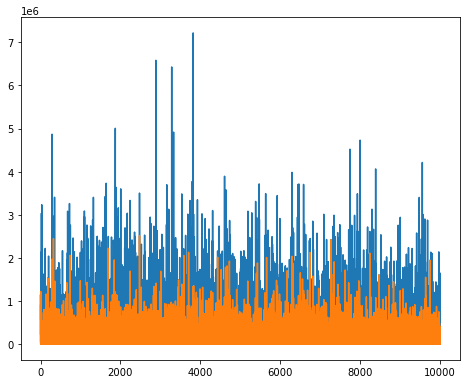

In [8]:
plt.figure()
plt.plot([gas_used(block) for block in blocks])
plt.plot(priority_gas)
print(np.median([gas_used(block) for block in blocks]))
print(np.mean([gas_used(block) for block in blocks]))

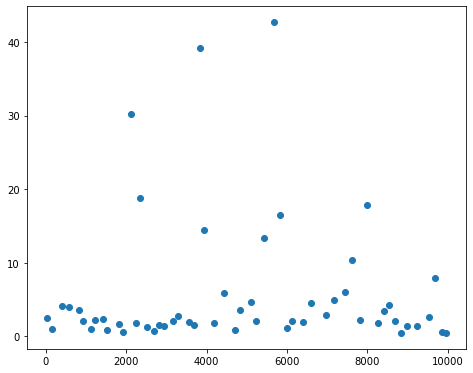

In [9]:
def get_local_maxs(l, within=100):
    def red_fun(a,b):
        if a == []:
            return [b]
        i = a[-1][0]
        r1 = a[-1][1]
        j = b[0]
        r2 = b[1]
        if j - i > within:
            a += [(j, r2)]
        elif r2 > r1:
            a[-1] = (j,r2)
        return a

    return reduce(red_fun, enumerate(l), [])

local_maxs = get_local_maxs(rewards)
indices = [i for i,_ in local_maxs]
maxs = [r for _,r in local_maxs]
plt.scatter(indices, maxs)
plt.show()